In [159]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from math import sqrt

x_train = pd.read_csv('x_train.csv', index_col='ID')
y_train = pd.read_csv('y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


In [160]:
ret=[f'RET_{k}' for k in range(20,0,-1)]
vol=[f'VOLUME_{k}' for k in range(20,0,-1)]
nb_sto = max(len(train.STOCK.unique()),len(test.STOCK.unique()))
nb_sub_ind = max(len(train.SUB_INDUSTRY.unique()),len(test.SUB_INDUSTRY.unique()))
nb_ind = max(len(train.INDUSTRY.unique()),len(test.INDUSTRY.unique()))
nb_grp_ind = max(len(train.INDUSTRY_GROUP.unique()),len(test.INDUSTRY_GROUP.unique()))
nb_sec = max(len(train.SECTOR.unique()),len(test.SECTOR.unique()))
print("Nombre total d'actions :", nb_sto)
print("Nombre total de sub-industries :", nb_sub_ind)
print("Nombre total d'industries :", nb_ind)
print("Nombre total de groupes industriels :", nb_grp_ind)
print("Nombre total de secteurs :", nb_sec)
print(max(test.SUB_INDUSTRY.unique()))
print(max(test.INDUSTRY.unique()))
print(max(test.INDUSTRY_GROUP.unique()))
print(max(test.SECTOR.unique()))

Nombre total d'actions : 5350
Nombre total de sub-industries : 182
Nombre total d'industries : 75
Nombre total de groupes industriels : 27
Nombre total de secteurs : 12
182
74
26
11


SECTOR
0      6304
1     21264
2     18967
3     55473
4     63519
5     17295
6     55123
7     87903
8     70843
9      5555
10    13295
11     3054
Name: DATE, dtype: int64

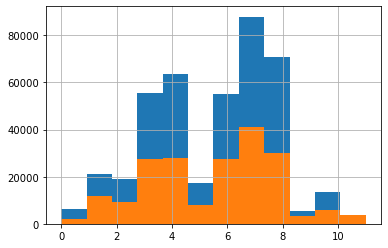

In [161]:
x_train.SECTOR.hist(bins=nb_sec)
test.SECTOR.hist(bins=nb_sec)
train.groupby(by='SECTOR').count()['DATE']
#test.groupby(by='STOCK').count()['DATE']

In [162]:
train_cl = train.copy()
test_cl = test.copy()
for indu in range(nb_grp_ind):
    for ret_t,vol_t in zip(ret,vol):
        med_ret_train = train[ret_t][train['INDUSTRY_GROUP']==indu].median()
        med_vol_train = train[vol_t][train['INDUSTRY_GROUP']==indu].median()
        med_ret_test = train[ret_t][train['INDUSTRY_GROUP']==indu].median()
        med_vol_test = train[vol_t][train['INDUSTRY_GROUP']==indu].median()
        
        train_cl[ret_t] = train_cl[ret_t].fillna(med_ret_train)
        train_cl[vol_t] = train_cl[vol_t].fillna(med_vol_train)
        test_cl[ret_t] = test_cl[ret_t].fillna(med_ret_test)
        test_cl[vol_t] = test_cl[vol_t].fillna(med_vol_test)

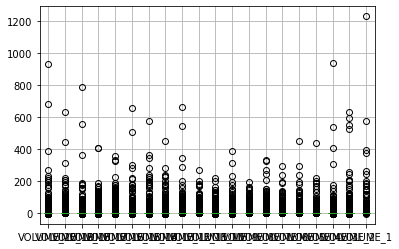

In [163]:
seuil_ret = 10000;
seuil_vol = 10000;
train_cl  = train_cl [np.all([train_cl[col]<seuil_ret for col in ret],axis=0)]
train_cl  = train_cl [np.all([train_cl[col]<seuil_vol for col in vol],axis=0)]
train_cl[vol].boxplot()

In [164]:
scaler = StandardScaler()
train_cl[ret+vol] = scaler.fit_transform(train_cl[ret+vol])
test_cl[ret+vol] = scaler.fit_transform(test_cl[ret+vol])
train_cl.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.548411,0.090205,-0.533128,0.118373,...,0.369549,0.051337,-0.135215,0.244455,0.000153,-0.398164,0.138928,-0.064255,0.044563,True
1,0,3,43,15,6,104,0.083572,-0.063399,-2.963086,-0.069950,...,-0.087656,0.067729,-0.089013,-0.628631,-0.081377,-0.916076,-0.084071,-1.047144,-0.073966,True
2,0,4,57,20,8,142,-0.029924,0.002790,-1.937575,0.079337,...,0.049558,-0.606663,-0.122245,-0.245831,-0.183962,-0.370059,-0.120714,-0.206441,-0.078988,False
3,0,8,1,1,1,2,0.958389,-0.116499,0.219699,0.007111,...,0.060757,1.015334,-0.089066,-0.082767,-0.249018,-0.416536,-0.221488,-1.108181,-0.208420,False
4,0,14,36,12,5,92,0.829460,-0.265982,-1.303374,-0.345611,...,-0.083555,-0.450444,0.132934,0.099901,0.042062,0.165460,0.337076,-1.231082,0.367047,False


In [165]:
arbre = ['SECTOR','INDUSTRY_GROUP','INDUSTRY','SUB_INDUSTRY','STOCK'];

def niv_arbre(df, lvl_arb, chemin, nb_min_per_mod):
    
    if (lvl_arb == 4 and df.shape[0]>nb_min_per_mod):
            return([[4,df.shape[0],chemin,chemin]])
    
    elif (df.shape[0]<nb_min_per_mod):
        
        if (lvl_arb == 0):
            return([lvl_arb, df.shape[0], chemin, chemin])
        
        return([lvl_arb, df.shape[0], chemin, chemin[0:len(chemin)-1]])
   
    else :
        res = []
   
        for sub_step in (df[arbre[lvl_arb+1]].unique()):
            sub_df = df[df[arbre[lvl_arb+1]]==sub_step]
            
            if sub_df.shape[0]>nb_min_per_mod:
                res = res + niv_arbre(sub_df,lvl_arb+1, chemin+[sub_step],nb_min_per_mod)
                
            elif (lvl_arb == -1):
                res = res + [[0,sub_df.shape[0],chemin+[sub_step],chemin+[sub_step]]]
                
            else : 
                res = res + [[lvl_arb,sub_df.shape[0],chemin+[sub_step],chemin]]
       
        return(res)

def creer_niv_arbre(df, nb_min_per_mod):
    
    grp_data = niv_arbre(df, -1, [], nb_min_per_mod) 
    
    for i in range(12):
        grp_data.append([0,0,0,[i]])
        
    models = np.unique(np.asarray(grp_data)[:,3])
    
    new_model = []
    for i in range(5,-1,-1):  
        for model in models:
            div = len(model)-1
            if i == div:
                new_model.append([div,model[div]])
    models = new_model
    
    
    return(grp_data,models)

grp_data, loc_mods = creer_niv_arbre(train,24000)

print('Nous allons creer', len(loc_mods), 'modèles afin de couvrir les', len(grp_data), 'groupes de données détectés.')

Nous allons creer 20 modèles afin de couvrir les 435 groupes de données détectés.


In [166]:
nb_feat = 20 #nb de jours pris en compte
features_base = ret[-nb_feat:]+vol[-nb_feat:]
target = 'RET'

In [167]:
print(len(grp_data),len(loc_mods))
print(loc_mods)
#print(grp_data)
loc_mods[0]

435 20
[[3, 108], [2, 46], [1, 3], [1, 14], [1, 15], [1, 16], [1, 20], [1, 21], [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11]]


[3, 108]

In [168]:
nb_shifts = 5 #nombre de features supplémentaires
shifts = range(1,nb_shifts+1)

new_features = []

statistics = ['median']
target_feature = 'RET'

for shift in range(1,nb_shifts+1):
    print(shift)
    for stat in statistics:
            
        feat = f'{target_feature}_{shift}'
        name = f'{target_feature}_{shift}_SUBDIVISION_{stat}'
        new_features.append(name)
        
        train_new = pd.Series()
        test_new = pd.Series()
        
        grille_train = pd.Series(index=range(0,418596))
        grille_test = pd.Series(index=range(418595,617024))
       

        for n in range(len(loc_mods)):    
            
            grp = loc_mods[n]
            niv = grp[0]
           
            if niv == 5:
                gb_features = ['STOCK', 'DATE']
            else:
                gb_features = [arbre[niv], 'DATE']
             
            train_set_sub = train_cl[train_cl[arbre[niv]]==grp[1]]
            test_set_sub = test_cl[test_cl[arbre[niv]]==grp[1]]
            
            train_set_sub = train_set_sub[grille_train.isna()]
            test_set_sub = test_set_sub[grille_test.isna()]
            
            train_index = train_set_sub.index
            test_index = test_set_sub.index
            
            grille_train[train_index] = 1
            grille_test[test_index] = 1
                
            train_new_sub = pd.Series(train_set_sub.groupby(gb_features)[feat].transform(stat),index=train_index)
            test_new_sub = pd.Series(test_set_sub.groupby(gb_features)[feat].transform(stat),index=test_index)
                
            train_new = pd.concat([train_new,train_new_sub])
            test_new = pd.concat([test_new,test_new_sub])
                        
        train_cl[name] = train_new
        test_cl[name] = test_new

1


<ipython-input-168-b5d240bbaa6d>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_new = pd.Series()
<ipython-input-168-b5d240bbaa6d>:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_new = pd.Series()
<ipython-input-168-b5d240bbaa6d>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  grille_train = pd.Series(index=range(0,418596))
<ipython-input-168-b5d240bbaa6d>:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  grille_test = pd.Series(index=range(418595,617024))
<ipython-input-168-b5d240bbaa6d>:

2
3
4
5


In [169]:
features = features_base + new_features
train_cl.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_19,VOLUME_19,RET_20,VOLUME_20,RET,RET_1_SUBDIVISION_median,RET_2_SUBDIVISION_median,RET_3_SUBDIVISION_median,RET_4_SUBDIVISION_median,RET_5_SUBDIVISION_median
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.548411,0.090205,-0.533128,0.118373,...,-0.398164,0.138928,-0.064255,0.044563,True,0.260143,-0.813372,-0.068628,0.003161,0.160548
1,0,3,43,15,6,104,0.083572,-0.063399,-2.963086,-0.069950,...,-0.916076,-0.084071,-1.047144,-0.073966,True,0.115822,-0.978886,-0.433684,-0.257448,0.126301
2,0,4,57,20,8,142,-0.029924,0.002790,-1.937575,0.079337,...,-0.370059,-0.120714,-0.206441,-0.078988,False,0.265624,-1.250678,-0.426038,-0.033428,0.514997
3,0,8,1,1,1,2,0.958389,-0.116499,0.219699,0.007111,...,-0.416536,-0.221488,-1.108181,-0.208420,False,0.463900,-0.039569,-0.421048,-0.306554,-0.359333
4,0,14,36,12,5,92,0.829460,-0.265982,-1.303374,-0.345611,...,0.165460,0.337076,-1.231082,0.367047,False,0.144378,-0.435882,-0.218924,0.021900,-0.031986


In [271]:
from sklearn.model_selection import train_test_split
acc2 = []
etage = []
N = 5
kf = KFold(n_splits=N,shuffle=True,random_state=1)


for fold, (train_index, test_index) in enumerate(kf.split(train_cl)):
    print("Fold :",fold)
    acc1 = []
    for sect in range(12):
        
        print("Sect :",sect)
        Z = train_cl.loc[train_index] 
        Z = Z[Z['SECTOR']==sect]
        X = Z[features]
        Y = Z[target]
        
        z = train_cl.loc[test_index]      
        z = z[z['SECTOR']==sect]
        x = z[features]
        y = z[target]
      
        acc0 = []  
        for n in range(1,20):
           
            print("n :",n)
    
            accmax = []
        
           
            rf_params = {
                'n_estimators': 500,
                'max_depth': n,
                'random_state': 0,
                'n_jobs': -1
            }
        
            model = RandomForestClassifier(**rf_params)
            model.fit(X,Y)
            y_pred = model.predict(x)
            acc0.append(accuracy_score(y, y_pred)/N)
            
        acc1.append(acc0)
            
    acc2.append(acc1)
    

ACCURACY = np.zeros(((len(acc1),len(acc0))))
    
for i_acc1 in range(len(acc2)):
    acc1 = acc2[i_acc1]
    for i_acc0 in range(len(acc1)): 
        acc0 = acc1[i_acc0]
        for i_acc in range(len(acc0)):
            ACCURACY[i_acc0][i_acc]+=acc2[i_acc1][i_acc0][i_acc]
        
        
print(acc)
print(acc2)
print('')
print(ACCURACY)
print("acc2",len(acc2),"acc1",len(acc1),"acc",len(acc0))

index_max = []
for i in ACCURACY:
    index_max.append(i.argmax())
print(index_max)

Fold : 0
Sect : 0
n : 1
n : 2
n : 3
n : 4
n : 5
n : 6
n : 7
n : 8
n : 9
n : 10
n : 11
n : 12
n : 13
n : 14
n : 15
n : 16
n : 17
n : 18
n : 19
Sect : 1
n : 1
n : 2
n : 3
n : 4
n : 5
n : 6
n : 7
n : 8
n : 9
n : 10
n : 11
n : 12
n : 13
n : 14
n : 15
n : 16
n : 17
n : 18
n : 19
Sect : 2
n : 1
n : 2
n : 3
n : 4
n : 5
n : 6
n : 7
n : 8
n : 9
n : 10
n : 11
n : 12
n : 13
n : 14
n : 15
n : 16
n : 17
n : 18
n : 19
Sect : 3
n : 1
n : 2
n : 3
n : 4
n : 5
n : 6
n : 7
n : 8
n : 9
n : 10
n : 11
n : 12
n : 13
n : 14
n : 15
n : 16
n : 17
n : 18
n : 19
Sect : 4
n : 1
n : 2
n : 3
n : 4
n : 5
n : 6
n : 7
n : 8
n : 9
n : 10
n : 11
n : 12
n : 13
n : 14
n : 15
n : 16
n : 17
n : 18
n : 19
Sect : 5
n : 1
n : 2
n : 3
n : 4
n : 5
n : 6
n : 7
n : 8
n : 9
n : 10
n : 11
n : 12
n : 13
n : 14
n : 15
n : 16
n : 17
n : 18
n : 19
Sect : 6
n : 1
n : 2
n : 3
n : 4
n : 5
n : 6
n : 7
n : 8
n : 9
n : 10
n : 11
n : 12
n : 13
n : 14
n : 15
n : 16
n : 17
n : 18
n : 19
Sect : 7
n : 1
n : 2
n : 3
n : 4
n : 5
n : 6
n : 7
n : 8
n :

[]
[[[0.25648234926585445, 0.253202124336145, 0.253358325523274, 0.25054670415495156], [0.2912119199013002, 0.2815317452785423, 0.2844737591344785, 0.2913542754104584], [0.2543710925082124, 0.2510861502596164, 0.2564374271484582, 0.2611529087633782]], [[0.2587818240412504, 0.25523686754753466, 0.2558814050918466, 0.2544311956171447], [0.28307075603617043, 0.29113452036916193, 0.28451570802647524, 0.29532954227649855], [0.24905561385099687, 0.2568205666316894, 0.26080797481636936, 0.26810073452256034]]]

[[0.51526417 0.50843899 0.50923973 0.5049779 ]
 [0.57428268 0.57266627 0.56898947 0.58668382]
 [0.50342671 0.50790672 0.5172454  0.52925364]]
acc2 2 acc1 3 acc 4


In [284]:
maxs = []
index_max = [13, 18, 17, 18, 18, 16, 16, 18, 17, 17, 18, 17]
for i in range(len(index_max)) : 
    maxs.append(ACCURACY[i][index_max[i]])

In [285]:
maxs

[0.5400316401864594,
 0.6936795985042498,
 0.5962546350438774,
 0.5644822074139778,
 0.5760021391634742,
 0.6078091511393104,
 0.5804786453581203,
 0.6284014684538439,
 0.5916304340554244,
 0.5684372456047299,
 0.7107057383802263,
 0.6995353100440579]

In [ ]:
#[4, 10, 11, 11, 11, 11, 10, 11, 10, 4, 11, 5]

In [ ]:
#[[0.5186360031720857, 0.5249801744647106, 0.5265662172878668, 0.5321173671689136, 0.5337034099920698, 0.528152260111023, 0.5202220459952419, 0.5186360031720857, 0.5297383029341792, 0.5051546391752577, 0.5138778747026169, 0.5162569389373514], [0.6016929226428404, 0.6186221490712438, 0.6353162473548084, 0.6543616270867623, 0.6585939336938632, 0.6691747002116153, 0.6743475193980719, 0.6785798260051729, 0.6846931577709852, 0.6872795673642135, 0.6910416176816365, 0.6903362332471197], [0.5284659989457038, 0.5413811280969952, 0.5453347390616763, 0.5479704797047971, 0.5582498682129678, 0.5648392198207697, 0.5727464417501318, 0.5727464417501318, 0.5801265155508698, 0.577227200843437, 0.5785450711649973, 0.5890880337374802], [0.5318611987381704, 0.5347453808021632, 0.53600721045516, 0.5398828301036503, 0.5425867507886435, 0.546372239747634, 0.5494366831906264, 0.5470031545741325, 0.5546642631816133, 0.552410995944119, 0.554393871113114, 0.5593510590356017], [0.5348709068010076, 0.5351070528967254, 0.5363664987405542, 0.5395938287153652, 0.5426637279596978, 0.5425850125944585, 0.546205919395466, 0.5493545340050378, 0.5506926952141058, 0.5573835012594458, 0.5623425692695214, 0.5652550377833753], [0.5336802544087886, 0.5446660884648742, 0.5478461983232148, 0.5576756287944492, 0.5573865278982365, 0.5686614628505349, 0.5787799942179821, 0.5894767273778548, 0.5926568372361954, 0.5995952587453021, 0.5955478461983232, 0.6042208730847065], [0.5369614512471655, 0.5454875283446712, 0.5498412698412698, 0.5536507936507936, 0.5614512471655329, 0.5608163265306122, 0.5587301587301587, 0.5610884353741497, 0.5659863945578232, 0.5663492063492064, 0.5693424036281179, 0.5676190476190476], [0.5496843182981628, 0.5575337011546556, 0.5647574085660656, 0.5685683408224788, 0.5733462260394744, 0.5819919230987999, 0.5901257038848757, 0.5968374950230362, 0.6008190660371993, 0.6057675900119447, 0.6099766793697742, 0.6152664808600193], [0.5372997388665396, 0.547251041005011, 0.5557202343143482, 0.5610840567435952, 0.5632013550709295, 0.5692709436092879, 0.5730115039875785, 0.5755522619803797, 0.5800691650786929, 0.5814806972969158, 0.5851506810642952, 0.5843743383442727], [0.5391539153915391, 0.5535553555355536, 0.5571557155715572, 0.5688568856885688, 0.5697569756975698, 0.5661566156615662, 0.5607560756075608, 0.558055805580558, 0.5625562556255626, 0.5544554455445545, 0.5634563456345635, 0.5553555355535553], [0.5663783377209477, 0.6137645731478, 0.63068822865739, 0.640842421963144, 0.6525009402030839, 0.6641594584430237, 0.6754418954494171, 0.6784505453177886, 0.6889808198570891, 0.6938698758931929, 0.696502444528018, 0.7010154193305754], [0.6432078559738135, 0.646481178396072, 0.6612111292962357, 0.6579378068739771, 0.6661211129296236, 0.6841243862520459, 0.6775777414075287, 0.6726677577741408, 0.6775777414075287, 0.6710310965630114, 0.6759410801963993, 0.6808510638297872]]

In [220]:
0.1709004776699168+0.17136632229998242+0.1717670498523636

0.5140338498222629

In [221]:
0.17286299748324452+0.17232787339537428+0.1728372941929689

0.5180281650715877

In [126]:
#x_train_cl.loc[list(train_index.transpose())]
#list(train_index.transpose())

In [134]:
train_index.shape

(313945,)

In [136]:
type(test_index)

numpy.ndarray

[[0.51368374 0.51359637 0.52794379 0.53370112 0.52941929 0.52754056
  0.53632782 0.53161847 0.53337793 0.53635372 0.5343023  0.53611321
  0.53424263 0.54003164 0.53557027 0.53447969 0.53605759 0.53895693
  0.53921286]
 [0.56632416 0.59630154 0.61065173 0.62808672 0.64003311 0.64937483
  0.65558909 0.66175152 0.66851447 0.67353942 0.67816903 0.67981395
  0.68426685 0.686521   0.68686669 0.6888873  0.69111209 0.69221423
  0.6936796 ]
 [0.51663136 0.53063681 0.53787575 0.54461414 0.55214864 0.56147655
  0.56832114 0.57229343 0.57909075 0.58092614 0.58083813 0.58249718
  0.58352048 0.58415432 0.58568714 0.59344191 0.59255461 0.59625464
  0.59386417]
 [0.52016538 0.52787314 0.53260602 0.53394846 0.53885974 0.54201778
  0.54364949 0.54640691 0.54804137 0.547525   0.55372078 0.5562194
  0.5563281  0.55818037 0.55866985 0.56138312 0.56241438 0.56131205
  0.56448221]
 [0.52254822 0.5308892  0.53645471 0.53982526 0.54403847 0.54816437
  0.55012511 0.55451069 0.55786574 0.55907974 0.56148306 0.56536527
  0.5666567  0.56861245 0.56987949 0.571222   0.5726361  0.57341113
  0.57600214]
 [0.51906602 0.53220711 0.54717063 0.55498235 0.56259816 0.57092975
  0.57746014 0.58549326 0.59202686 0.59444994 0.5999433  0.60010782
  0.60427387 0.60317762 0.60530425 0.60524638 0.60780915 0.60421346
  0.60409679]
 [0.52282678 0.5321189  0.54049471 0.54741415 0.55067408 0.55548324
  0.5582098  0.56280497 0.56471225 0.56832661 0.57051642 0.57249195
  0.57353549 0.57547421 0.5771773  0.57553616 0.58047865 0.57921675
  0.57817357]
 [0.53502742 0.54569452 0.55399079 0.56083923 0.5663537  0.57236735
  0.57998522 0.58777403 0.59401269 0.59977814 0.60507683 0.6094862
  0.61305994 0.61735919 0.62084518 0.62249914 0.62517566 0.62626578
  0.62840147]
 [0.51870072 0.54124024 0.54730312 0.55271206 0.55671843 0.56121895
  0.56581283 0.57053248 0.57285974 0.57742777 0.57789643 0.58084669
  0.58228961 0.58492764 0.58664239 0.58825396 0.58820685 0.59163043
  0.59068148]
 [0.51721471 0.53179109 0.53386782 0.54017013 0.54245918 0.54471982
  0.54541499 0.5525194  0.55325773 0.55659431 0.55875016 0.56346252
  0.56253079 0.56713313 0.56169534 0.56019766 0.56437574 0.56843725
  0.5633514 ]
 [0.53224287 0.55926165 0.59931478 0.61894795 0.63474005 0.6422493
  0.65158526 0.66461408 0.6756862  0.68227585 0.68885815 0.69527244
  0.69828612 0.70017645 0.70516777 0.70543597 0.70545858 0.70798698
  0.71070574]
 [0.63695271 0.65258615 0.66380941 0.67573817 0.6802942  0.69155512
  0.69269509 0.69222291 0.6983776  0.69638264 0.69470595 0.69806631
  0.69776252 0.69421044 0.69515138 0.69565877 0.69330091 0.69953531
  0.69483423]]

[0.5400316401864594,
 0.6936795985042498,
 0.5962546350438774,
 0.5644822074139778,
 0.5760021391634742,
 0.6078091511393104,
 0.5804786453581203,
 0.6284014684538439,
 0.5916304340554244,
 0.5684372456047299,
 0.7107057383802263,
 0.6995353100440579]

[14, 19, 18, 19, 19, 17, 17, 19, 18, 18, 19, 18]

[]
[[[0.10100076982294073, 0.10300230946882216, 0.10762124711316397, 0.10823710546574287, 0.10700538876058507, 0.10731331793687451, 0.10669745958429562, 0.1071593533487298, 0.10823710546574287, 0.10962278675904542, 0.10808314087759816, 0.10792917628945342, 0.10746728252501925, 0.10638953040800617, 0.1107005388760585, 0.10977675134719014, 0.1100846805234796, 0.11023864511162433, 0.10669745958429562], [0.11246734742341487, 0.11864165281405843, 0.12120636428401806, 0.1251959154595108, 0.12790311090002376, 0.129375445262408, 0.13070529565423888, 0.13217763001662314, 0.13369745903585845, 0.13436238423177393, 0.1352172880550938, 0.13569223462360486, 0.13592970790786035, 0.13597720256471146, 0.13683210638803134, 0.1375445262407979, 0.1373545476133935, 0.13797197815245785, 0.13911184991688436], [0.10341745531019979, 0.10536277602523661, 0.10615141955835963, 0.10783385909568874, 0.1086750788643533, 0.11072555205047319, 0.11288117770767614, 0.11319663512092534, 0.11351209253417456, 0.114931650893796, 0.11456361724500526, 0.11629863301787594, 0.11603575184016823, 0.11698212407991589, 0.11698212407991589, 0.11945320715036803, 0.11845425867507886, 0.11887486855941114, 0.11803364879074658], [0.1055731922398589, 0.10633156966490301, 0.1073015873015873, 0.1073015873015873, 0.1080599647266314, 0.1092768959435626, 0.10887125220458553, 0.10971781305114639, 0.1101410934744268, 0.10982363315696649, 0.11068783068783068, 0.11137566137566138, 0.11132275132275131, 0.11185185185185184, 0.11130511463844797, 0.11218694885361553, 0.11211640211640213, 0.11282186948853616, 0.11354497354497355], [0.10204309656823622, 0.10485235434956106, 0.10627294493216281, 0.10687948922585795, 0.10751795690343176, 0.10914604948124502, 0.10949720670391061, 0.11003990422984837, 0.11059856344772545, 0.11085395051875499, 0.11150837988826816, 0.11316839584996011, 0.11339185953711092, 0.11388667198723064, 0.11313647246608141, 0.1136951316839585, 0.11350359138068636, 0.11458898643256185, 0.11411013567438148], [0.10318471337579618, 0.10689056166763174, 0.11065431383902721, 0.11314418066010423, 0.11354950781702373, 0.11586566299942096, 0.11737116386797915, 0.11806601042269833, 0.12003474232773596, 0.11899247249565721, 0.12125072379849451, 0.11957151129125651, 0.12096120440069484, 0.12154024319629415, 0.12194557035321367, 0.12275622466705269, 0.12321945570353214, 0.1224088013896931, 0.11986103068905615], [0.10440480524208226, 0.10649799781579905, 0.10780851838369129, 0.10937386239534037, 0.10961048416454314, 0.1112304331998544, 0.11181288678558428, 0.11248634874408445, 0.11328722242446305, 0.11437932289770658, 0.11425191117582818, 0.1141062977793957, 0.11421550782672005, 0.11550782672005824, 0.11574444848926102, 0.11592646523480162, 0.11589006188569348, 0.11609028030578813, 0.11585365853658536], [0.10698340011448197, 0.10903262736119061, 0.10998282770463652, 0.11129937034917001, 0.11287922152261018, 0.11403548941041786, 0.11553520320549512, 0.11674871207784773, 0.1179164281625644, 0.11910704064109903, 0.1201831711505438, 0.12100744132799084, 0.12210646823125357, 0.12271322266742987, 0.12402976531196337, 0.12413279908414425, 0.12439610761305095, 0.12463651974813968, 0.1247967945048655], [0.10217513331462251, 0.10822340724108896, 0.11025820937412294, 0.11094583216390681, 0.1118860510805501, 0.11317709795116475, 0.11351389278697728, 0.11428571428571428, 0.1148049396575919, 0.11585742351950604, 0.11581532416502946, 0.11657311254560762, 0.11647488071849565, 0.11693797361773786, 0.11682570867246703, 0.11800449059781085, 0.11742913275329778, 0.11836935166994107, 0.11789222565253998], [0.10515837104072398, 0.1069683257918552, 0.10751131221719457, 0.10678733031674208, 0.10859728506787329, 0.11058823529411765, 0.11058823529411765, 0.11040723981900454, 0.11113122171945702, 0.1127601809954751, 0.11131221719457014, 0.11384615384615385, 0.11257918552036199, 0.11167420814479638, 0.11366515837104071, 0.11221719457013575, 0.11203619909502263, 0.11420814479638008, 0.10986425339366516], [0.10877458396369137, 0.11384266263237519, 0.12178517397881997, 0.12556732223903178, 0.12700453857791225, 0.12798789712556732, 0.12957639939485627, 0.13139183055975795, 0.13479576399394858, 0.13623298033282905, 0.13857791225416036, 0.1401664145234493, 0.14069591527987896, 0.14024205748865354, 0.14069591527987896, 0.14107413010590014, 0.14084720121028743, 0.14334341906202724, 0.1418305597579425], [0.1292604501607717, 0.13086816720257236, 0.132475884244373, 0.13665594855305466, 0.13729903536977492, 0.13729903536977492, 0.14083601286173633, 0.13633440514469453, 0.14019292604501607, 0.13794212218649518, 0.13954983922829584, 0.14115755627009646, 0.13987138263665594, 0.13794212218649518, 0.13954983922829584, 0.14019292604501607, 0.13954983922829584, 0.13890675241157557, 0.14019292604501607]], [[0.10193548387096774, 0.10290322580645161, 0.10258064516129033, 0.10419354838709678, 0.10354838709677419, 0.1043548387096774, 0.10741935483870968, 0.10483870967741934, 0.10258064516129033, 0.10483870967741934, 0.10354838709677419, 0.10451612903225807, 0.10290322580645161, 0.10403225806451613, 0.1038709677419355, 0.10274193548387096, 0.10483870967741934, 0.10516129032258063, 0.10500000000000001], [0.11159488878371984, 0.11930903928064363, 0.12101277804070043, 0.12470421202082346, 0.12749645054424988, 0.13014671083767154, 0.13109323237103646, 0.1315664931377189, 0.13355418835778515, 0.13379081874112636, 0.13445338381448177, 0.13487931850449597, 0.13677236157122574, 0.13644107903454802, 0.13644107903454802, 0.13648840511121627, 0.1373402744912447, 0.13700899195456698, 0.13719829626123994], [0.10437114507910968, 0.10490748189863235, 0.10689192813086619, 0.10753553231429339, 0.10850093858943417, 0.11043175113971575, 0.11102172164119066, 0.11246983105390185, 0.11413247519442209, 0.11418610887637437, 0.11295253419147225, 0.11456154465004023, 0.11493698042370608, 0.1133279699651381, 0.11429337624027888, 0.11574148565299007, 0.11617055510860821, 0.11622418879056047, 0.11751139715741485], [0.1024483829709483, 0.10670564589804495, 0.1084048967659419, 0.1089895852366161, 0.110012790060296, 0.11065229307509591, 0.11030513429563311, 0.11149278275169013, 0.11173031244290152, 0.11178512698702722, 0.11337474876667275, 0.11350264936963275, 0.11381326511967842, 0.11390462269322126, 0.11425178147268408, 0.11476338388452403, 0.11441622510506122, 0.1148364699433583, 0.1151288141786954], [0.1034831285958638, 0.10502254703778573, 0.10649976675478152, 0.1067952106981807, 0.1071995024102006, 0.10855232467734413, 0.10918986160783703, 0.11030943865650755, 0.11152231379256725, 0.11116467112424196, 0.1118955061421241, 0.11292178510340538, 0.11273518892862697, 0.11388586533976053, 0.11377701757113978, 0.11424350800808583, 0.11447675322655886, 0.11512983983828332, 0.11579847613123931], [0.10879120879120878, 0.11093117408906883, 0.11295546558704453, 0.11278195488721805, 0.11417004048582995, 0.11561596298438404, 0.1158473105841527, 0.1178716020821284, 0.1189705031810295, 0.12012724117987277, 0.12047426257952573, 0.121631000578369, 0.12319259687680742, 0.1209947946790052, 0.12238288027761712, 0.12192018507807982, 0.1218045112781955, 0.12215153267784847, 0.1229034123770966], [0.10569324712643677, 0.10802801724137931, 0.10964439655172413, 0.11151221264367817, 0.11232040229885058, 0.11300287356321839, 0.11329022988505748, 0.11395474137931035, 0.11388290229885059, 0.11413433908045978, 0.11508620689655173, 0.11530172413793102, 0.11643318965517242, 0.11589439655172414, 0.11663074712643677, 0.11646910919540229, 0.11702586206896552, 0.11616379310344827, 0.11666666666666667], [0.10780246632948798, 0.11057566630675683, 0.11234869580042053, 0.11314428595783373, 0.11447405807808149, 0.11566744331420128, 0.11681536625561176, 0.11804284821276353, 0.11934988918565666, 0.11987270557481389, 0.12108882195828834, 0.12219128260498949, 0.12230493834176279, 0.12352105472523726, 0.12371426947775188, 0.12380519406717054, 0.12464624651929306, 0.12479399897709838, 0.12508950389270898], [0.10741522442662163, 0.10872379344308429, 0.1097368791332489, 0.11090474180385534, 0.1116504854368932, 0.11256507668495849, 0.11333896158716758, 0.11383143379766428, 0.11459124806528775, 0.11588574644716476, 0.11587167581257915, 0.11646264246517517, 0.11646264246517517, 0.11719431546362742, 0.11723652736738428, 0.11815111861544955, 0.11770085830870973, 0.11854509638384692, 0.11751794005909666], [0.10303030303030303, 0.10766488413547237, 0.10677361853832441, 0.11105169340463458, 0.11140819964349376, 0.11194295900178253, 0.10944741532976827, 0.11122994652406418, 0.11122994652406418, 0.11016042780748662, 0.11158645276292337, 0.11087344028520499, 0.11265597147950088, 0.1106951871657754, 0.11176470588235295, 0.11016042780748662, 0.11212121212121211, 0.11051693404634581, 0.11122994652406418], [0.10534883720930233, 0.1117829457364341, 0.11968992248062016, 0.12573643410852714, 0.12914728682170543, 0.13054263565891472, 0.13271317829457366, 0.1344186046511628, 0.13643410852713178, 0.13744186046511628, 0.13883720930232557, 0.13914728682170543, 0.13984496124031007, 0.14046511627906977, 0.14100775193798448, 0.14193798449612402, 0.14054263565891473, 0.14131782945736432, 0.14310077519379844], [0.12873563218390804, 0.129064039408867, 0.13366174055829227, 0.13431855500821016, 0.13464696223316913, 0.13399014778325122, 0.13464696223316913, 0.13464696223316913, 0.13464696223316913, 0.13530377668308702, 0.13464696223316913, 0.13333333333333333, 0.13530377668308702, 0.13431855500821016, 0.13399014778325122, 0.13497536945812807, 0.13431855500821016, 0.1359605911330049, 0.13333333333333333]], [[0.10243902439024391, 0.10259638080251769, 0.1054287962234461, 0.1052714398111723, 0.1049567269866247, 0.1043273013375295, 0.1077891424075531, 0.1088906372934697, 0.1065302911093627, 0.10763178599527931, 0.10841856805664832, 0.1077891424075531, 0.1065302911093627, 0.1085759244689221, 0.1043273013375295, 0.1040125885129819, 0.10668764752163651, 0.1049567269866247, 0.1082612116443745], [0.11466986794717886, 0.11966386554621848, 0.12350540216086434, 0.1262905162064826, 0.12945978391356544, 0.13176470588235295, 0.1330612244897959, 0.13488595438175272, 0.13536614645858341, 0.13695078031212485, 0.1375750300120048, 0.1375750300120048, 0.13805522208883553, 0.13920768307322928, 0.13891956782713086, 0.13949579831932774, 0.1391596638655462, 0.14016806722689074, 0.1399279711884754], [0.10459859703819174, 0.10636528968563264, 0.10740452065471551, 0.10828786697843595, 0.11005455962587685, 0.11187321382177189, 0.11312029098467133, 0.1137957911145752, 0.11613406079501169, 0.11639386853728242, 0.11748506105481944, 0.11712133021564042, 0.11608209924655755, 0.11727721486100287, 0.11842036892699404, 0.11940763834762276, 0.11904390750844376, 0.12153806183424265, 0.12117433099506365], [0.10469713456655785, 0.10525933986216902, 0.10642002176278564, 0.10636561479869425, 0.10785273848385928, 0.10825172288719623, 0.10866884294523031, 0.10899528472977875, 0.10874138556401887, 0.10859630032644178, 0.10972071091766414, 0.11060935799782372, 0.10970257526296698, 0.11066376496191513, 0.11120783460282917, 0.11175190424374319, 0.11273122959738846, 0.11115342763873777, 0.11264055132390279], [0.10623145400593473, 0.10702795564579104, 0.10823051694518196, 0.10829298766203341, 0.10994846165859753, 0.11029205060128064, 0.10982352022489458, 0.11063563954396376, 0.11116664063720132, 0.11080743401530532, 0.11180696548492894, 0.11275964391691395, 0.11311885053880992, 0.11327502733093861, 0.11330626268936436, 0.11364985163204748, 0.11447758863032953, 0.11388411682024051, 0.11493050132750274], [0.10331588132635253, 0.10727166957533449, 0.10919139034322281, 0.11180919139034322, 0.11227457824316463, 0.11436881908086097, 0.11564863292611985, 0.11721931355439208, 0.11809191390343224, 0.1186154741128563, 0.11942990110529376, 0.11896451425247237, 0.11954624781849912, 0.12006980802792322, 0.11855730075625363, 0.11838278068644562, 0.12094240837696335, 0.11867364746945899, 0.11972076788830714], [0.1037473913437982, 0.10521731240359314, 0.10679611650485436, 0.10737682605934126, 0.10853824516831503, 0.10964522275655567, 0.10999001905453225, 0.11096996642772887, 0.11173214771799292, 0.11287541965338899, 0.11345612920787587, 0.11332909899283186, 0.11332909899283186, 0.11423645767171764, 0.11432719353960621, 0.1140912802830959, 0.1150349333091371, 0.11547046547500225, 0.11488975592051538], [0.10736220695918715, 0.10943974570017596, 0.11075665550320712, 0.11258443548844865, 0.11350400181642732, 0.11476414826587955, 0.11659192825112108, 0.11841970823636261, 0.11998637679514106, 0.120996764488846, 0.12174604075608786, 0.1233354146562979, 0.1240619855821082, 0.12482261452006585, 0.12537889538513936, 0.12619628767667596, 0.12641198842027587, 0.12699097462678094, 0.12722938071181245], [0.10571854798607658, 0.1089436669744974, 0.10979612133267032, 0.11089010442565887, 0.11134474675001775, 0.11235348440718904, 0.11356112808126732, 0.11482560204589046, 0.11523762165234071, 0.11563543368615473, 0.11604745329260495, 0.1168288697875968, 0.11695673794132273, 0.11724088939404702, 0.11799389074376643, 0.11776656958158697, 0.11836328763230801, 0.11829224976912693, 0.11905945869148256], [0.10480349344978165, 0.10550218340611354, 0.10550218340611354, 0.10602620087336245, 0.10585152838427947, 0.10759825327510916, 0.10707423580786027, 0.10864628820960698, 0.1091703056768559, 0.10707423580786027, 0.11004366812227073, 0.1091703056768559, 0.11004366812227073, 0.11231441048034933, 0.10724890829694322, 0.1091703056768559, 0.11144104803493449, 0.11353711790393013, 0.11074235807860262], [0.10547592796765895, 0.11201764057331862, 0.11797133406835722, 0.1217199558985667, 0.12414553472987873, 0.12590959206174202, 0.1276736493936053, 0.1312752664461595, 0.13281881661153988, 0.1350973906651966, 0.13495038588754132, 0.13737596471885336, 0.138257993384785, 0.13774347666299153, 0.14046306504961412, 0.13972804116133775, 0.13972804116133775, 0.1392135244395443, 0.13987504593899303], [0.129776247848537, 0.13115318416523236, 0.13390705679862308, 0.13356282271944922, 0.13459552495697075, 0.13941480206540446, 0.1370051635111876, 0.13941480206540446, 0.140447504302926, 0.13941480206540446, 0.13838209982788297, 0.14079173838209982, 0.14079173838209982, 0.14113597246127368, 0.140447504302926, 0.13838209982788297, 0.1370051635111876, 0.13803786574870913, 0.13597246127366608]], [[0.10169491525423728, 0.09959644874899112, 0.1033091202582728, 0.10492332526230833, 0.10347054075867634, 0.10556900726392252, 0.10621468926553672, 0.10411622276029056, 0.10734463276836159, 0.10605326876513317, 0.10540758676351895, 0.10799031476997578, 0.1102502017756255, 0.11234866828087167, 0.10766747376916867, 0.10782889426957223, 0.10815173527037933, 0.1089588377723971, 0.1102502017756255], [0.1150308853809197, 0.11992679020819035, 0.12271791352093342, 0.12642415923129718, 0.12811713566689545, 0.12930679478380233, 0.13013040494166095, 0.1318233813772592, 0.13296728437428507, 0.13429421185083507, 0.1358499199267902, 0.13594143216655227, 0.13713109128345918, 0.13781743308167466, 0.13717684740334019, 0.13795470144131777, 0.13859528711965224, 0.13891557995881948, 0.13873255547929536], [0.10201377848436673, 0.10699523052464228, 0.10858505564387917, 0.10990990990990993, 0.11250662427133015, 0.11372549019607843, 0.11558028616852148, 0.1167461579226285, 0.11822999470058293, 0.1179650238473768, 0.11822999470058293, 0.1172760996290408, 0.11812400635930047, 0.11775304716481187, 0.11791202967673556, 0.11939586645468998, 0.11875993640699523, 0.11844197138314785, 0.1178060413354531], [0.10420805490337728, 0.10512913129853711, 0.10594184576485462, 0.10619469026548674, 0.10691710312443561, 0.10742279212569983, 0.1081993859490699, 0.10803684305580638, 0.10870507495033413, 0.10832580819938595, 0.10973451327433628, 0.11011378002528445, 0.11011378002528445, 0.11009571970381074, 0.11074589127686474, 0.11069171031244356, 0.11123351995665523, 0.11051110709770633, 0.11052916741918006], [0.10590485297633279, 0.1068770419953781, 0.1082795441867878, 0.10976173400270939, 0.11043111004860946, 0.11059048529763327, 0.11148298669216669, 0.1124233006614073, 0.11261455096023587, 0.1135070523547693, 0.1127739262092597, 0.11325205195633119, 0.11341142720535499, 0.11326798948123355, 0.11486174197147184, 0.11425611602518129, 0.11495736712088614, 0.11529205514383616, 0.11486174197147184], [0.10103567318757192, 0.10322209436133487, 0.10747986191024166, 0.11001150747986191, 0.11237054085155351, 0.11426927502876869, 0.11582278481012658, 0.11789413118527044, 0.11841196777905638, 0.11950517836593785, 0.12042577675489068, 0.12077100115074799, 0.1213463751438435, 0.12186421173762947, 0.1214614499424626, 0.1218066743383199, 0.12105868814729574, 0.12031070195627158, 0.1213463751438435], [0.10539502560351136, 0.10802852962692026, 0.10929041697147038, 0.1100768105340161, 0.11040599853694222, 0.11093635698610096, 0.11183247988295537, 0.11320409656181418, 0.11314923189465984, 0.11362472567666422, 0.11422823701536211, 0.11464886613021215, 0.11486832479882955, 0.11550841258229701, 0.11607534747622532, 0.11474030724213606, 0.11671543525969277, 0.11638624725676665, 0.11594732991953183], [0.10727374929735807, 0.10933108487914558, 0.11160202360876896, 0.11300730747611017, 0.11363687464867904, 0.11503091624508151, 0.11622259696458685, 0.11802136031478358, 0.11886453063518831, 0.12104553119730185, 0.12176503653738055, 0.12240584598088815, 0.12327150084317032, 0.12409218662169759, 0.12478920741989882, 0.12478920741989882, 0.12522765598650926, 0.12538504777965148, 0.1261495222034851], [0.10267787748180597, 0.10874019642478627, 0.10984243623260086, 0.11080336324454179, 0.11163710874019643, 0.11247085423585106, 0.11374266939871405, 0.11467533385148025, 0.1146188087331308, 0.11574931110012013, 0.11642761252031371, 0.11613085564897903, 0.11717657033844416, 0.11750158976895357, 0.11802444711368613, 0.11803857839327352, 0.11784074047905038, 0.11890058644810289, 0.11847664806048189], [0.10368968779564806, 0.10614947965941343, 0.10804162724692526, 0.10955534531693471, 0.10860927152317881, 0.1076631977294229, 0.11031220435193945, 0.11069063386944182, 0.11106906338694418, 0.11523178807947018, 0.11390728476821192, 0.11447492904446548, 0.11428571428571428, 0.11504257332071902, 0.1140964995269631, 0.11390728476821192, 0.11598864711447492, 0.11561021759697257, 0.11428571428571428], [0.10525139664804468, 0.10934823091247672, 0.11754189944134079, 0.12059590316573557, 0.12551210428305398, 0.12692737430167597, 0.12886405959031658, 0.1318435754189944, 0.13430167597765363, 0.13564245810055867, 0.13735567970204843, 0.13884543761638735, 0.1383240223463687, 0.1400372439478585, 0.14011173184357542, 0.14078212290502795, 0.14160148975791434, 0.142048417132216, 0.14391061452513967], [0.11967479674796748, 0.13008130081300812, 0.13170731707317074, 0.13691056910569105, 0.13691056910569105, 0.14113821138211383, 0.1408130081300813, 0.1421138211382114, 0.14146341463414633, 0.14113821138211383, 0.14113821138211383, 0.1421138211382114, 0.14048780487804877, 0.1391869918699187, 0.1408130081300813, 0.14016260162601626, 0.14016260162601626, 0.14308943089430895, 0.1421138211382114]], [[0.10661354581673306, 0.1054980079681275, 0.10900398406374504, 0.11107569721115537, 0.11043824701195219, 0.10597609561752988, 0.10820717131474104, 0.10661354581673306, 0.10868525896414342, 0.10820717131474104, 0.10884462151394422, 0.10788844621513945, 0.10709163346613546, 0.10868525896414342, 0.10900398406374504, 0.1101195219123506, 0.10629482071713148, 0.10964143426294821, 0.10900398406374504], [0.11256117455138663, 0.11876019575856445, 0.12220927522721976, 0.12547191796783969, 0.12705663015614077, 0.12878116989046842, 0.1305989279888138, 0.13129806571894662, 0.13292938708925658, 0.13414122582148685, 0.13507340946166396, 0.13572593800978794, 0.13637846655791191, 0.13707760428804475, 0.13749708692612445, 0.13740386856210673, 0.13866231647634583, 0.13814961547424842, 0.1387089256583547], [0.10223038572553136, 0.10700603516137497, 0.10884282340593021, 0.11104696929939648, 0.11241144056678036, 0.11472054578850695, 0.1157176594069798, 0.11608501705589085, 0.11708213067436368, 0.11744948832327473, 0.11760692731566517, 0.11723956966675413, 0.11834164261348727, 0.11881395959065862, 0.11807924429283652, 0.11944371556022042, 0.12012595119391237, 0.12117554447651535, 0.11933875623196011], [0.10323861073522778, 0.10444745151105098, 0.10453766350924673, 0.10509697789806045, 0.10601714027965718, 0.10641407307171853, 0.10760487144790257, 0.10816418583671628, 0.10872350022552998, 0.10899413622011726, 0.11020297699594046, 0.11061795218764096, 0.11137573297248533, 0.11166441136671176, 0.11115922417681552, 0.11198917456021651, 0.1119170049616599, 0.11198917456021651, 0.11263870094722599], [0.1048856874412778, 0.10710930159724397, 0.1071719386157219, 0.10809583463827122, 0.10894143438772315, 0.10958346382712184, 0.11013153773880364, 0.11110241152521141, 0.1119636705292828, 0.1127466332602568, 0.11349827748199186, 0.11326338866269965, 0.11399937362981523, 0.11429689946758534, 0.11479799561540871, 0.11537738803632946, 0.11522079549013467, 0.11451612903225808, 0.11630128405887881], [0.102738541366388, 0.10389161141539349, 0.10688959354280772, 0.10723551455750938, 0.11023349668492362, 0.11081003170942634, 0.11277025079273566, 0.11444220236379361, 0.11651772845200345, 0.11720957048140675, 0.11836264053041223, 0.11916978956471606, 0.11922744306716633, 0.11870856154511386, 0.12095704814067454, 0.12038051311617182, 0.12078408763332374, 0.12066878062842316, 0.12026520611127126], [0.1035863068284731, 0.10434703857996738, 0.10695526172794782, 0.10907444303568195, 0.1097989494656765, 0.11066835718166998, 0.11128418764716537, 0.11218982068465858, 0.11266074986415504, 0.11331280565115016, 0.11349393225864879, 0.1151059590653867, 0.11468936786813984, 0.11432711465314253, 0.11439956529614201, 0.11430900199239269, 0.1158123528346314, 0.1151059590653867, 0.11481615649338887], [0.10560559986229848, 0.10731539388375695, 0.10930059096907455, 0.11080383269263872, 0.11185954443743187, 0.11286935567158185, 0.11482012737391703, 0.11654139652303633, 0.11789546158701017, 0.11875609616156979, 0.12029376326811636, 0.12054621607665386, 0.12131504962992715, 0.12221010958746917, 0.12293304263009926, 0.1235756497791038, 0.12449365999196742, 0.12445923460898503, 0.12513626714097195], [0.1007139322824627, 0.1066091750901251, 0.10766947055912915, 0.10916802148865483, 0.11020004241181876, 0.11065243514526049, 0.1116561815225843, 0.11291439881246908, 0.11360712518555172, 0.11429985155863434, 0.1137343606418322, 0.11485120520251643, 0.11521877429843783, 0.11605287340072099, 0.11656181522584293, 0.11629320704036192, 0.11687283523008411, 0.11752314978440659, 0.11773520887820739], [0.10053285968028418, 0.10550621669626999, 0.10603907637655416, 0.10674955595026643, 0.10799289520426288, 0.10692717584369449, 0.10799289520426288, 0.11154529307282415, 0.11065719360568385, 0.11136767317939608, 0.1119005328596803, 0.11509769094138544, 0.11296625222024867, 0.11740674955595028, 0.11492007104795736, 0.1147424511545293, 0.11278863232682061, 0.11456483126110124, 0.11722912966252222], [0.1073921200750469, 0.11227016885553472, 0.12232645403377111, 0.12532833020637899, 0.12893058161350843, 0.13088180112570355, 0.1327579737335835, 0.1356848030018762, 0.1373358348968105, 0.1378611632270169, 0.13913696060037523, 0.1397373358348968, 0.14116322701688555, 0.14168855534709193, 0.14288930581613507, 0.1419136960600375, 0.1427392120075047, 0.1420637898686679, 0.1419887429643527], [0.12950558213716107, 0.1314194577352472, 0.1320574162679426, 0.1342902711323764, 0.1368421052631579, 0.13971291866028707, 0.1393939393939394, 0.13971291866028707, 0.1416267942583732, 0.14258373205741626, 0.14098883572567783, 0.14066985645933014, 0.14130781499202552, 0.1416267942583732, 0.14035087719298245, 0.14194577352472088, 0.1422647527910686, 0.14354066985645933, 0.14322169059011164]]]

In [124]:
g = np.array([0,1,2])

In [131]:
x_train_cl.shape

(418594, 46)